# Pre-employment coursework
## Exercise 5a - Generative Adversarial Network w/ MNIST

- **Author:** Jan Xu
- **Model:** A DCGAN with WGAN-GP loss
- **Aim:** Model should be trained to generate new instances of the MNIST training dataset.
- **Sources:** Gulrajani, (2017), *Improved Training of Wasserstein GANs*, https://arxiv.org/pdf/1704.00028.pdf

In [21]:
# Imports
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

import torchvision
from torchvision.transforms import transforms

from IPython.display import display, clear_output

from utils_MNIST import *

print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1


## Load the MNIST dataset

In [22]:
# Define transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Load data
train_set = torchvision.datasets.MNIST(root='../data', train=True,
                                       download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='../data', train=False,
                                      download=True, transform=transform)

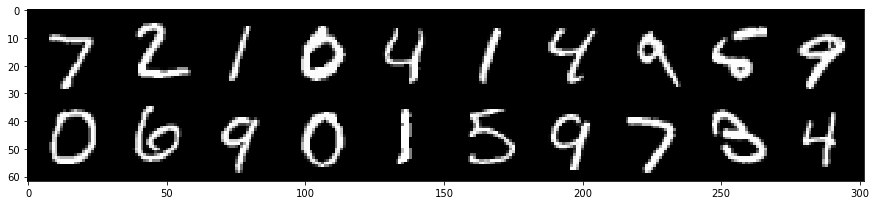

In [23]:
test_loader = DataLoader(test_set, batch_size=20)
test_images, _ = next(iter(test_loader))
imgviz(test_images, save_fname="./original_MNIST.png", nrow=10)

## Define model

In [24]:
"""
class CriticNet(nn.Module):
"""
#A three hidden-layer critic neural network
"""
    def __init__(self):
        super(CriticNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.layers = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, n_out)
        )

    def forward(self, inputs):
        output = self.layers(inputs)
        return output
"""
    
class CriticNet(nn.Module):
    """
    A three hidden-layer critic neural network
    """
    def __init__(self):
        super(CriticNet, self).__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(1, 48, 3, 2, 1), # 48 14 14
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 96, 3, 2, 1), # 96 7 7
            nn.LeakyReLU(0.1),
            nn.Conv2d(96, 192, 3, 2, 1), # 192 4 4
            nn.LeakyReLU(0.1),
            nn.Flatten(start_dim=1),
            nn.Linear(192 * 4 * 4, 1)
        )

    def forward(self, inputs):
        output = self.layers(inputs)
        return output

In [25]:
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features):
        super(GeneratorNet, self).__init__()
        
        self.linear = nn.Linear(n_features, 4 * 4 * 192)
        self.BN = nn.BatchNorm1d(4 * 4 * 192)
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(192, 96, 2, 2, 0), # 96 8 8
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 3, 2, 1), # 48 15 15
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 2, 2, 1), # 24 28 28
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 1, 3, 1, 1), # 1 28 28
            nn.Tanh()
        )

    def forward(self, inputs):
        linear = self.relu(self.BN(self.linear(inputs)))
        linear = linear.view(-1, 192, 4, 4)
        generated_img = self.layers(linear)
        return generated_img

In [26]:
class WGAN_GP(nn.Module):
    """
    A Generative Adversarial Network model.
    """
    def __init__(self, latent_dim, lambd=10):
        super(WGAN_GP, self).__init__()
        self.latent_dim = latent_dim
        self.lambd = lambd
        self.critic = CriticNet()
        self.generator = GeneratorNet(self.latent_dim)
        self.d_optimizer = None
        self.g_optimizer = None
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def set_optimizers(self, d_optimizer, g_optimizer):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
    def sample(self, batch_size):
        """
        Generates Gaussian sampled random values for image generation.
        """
        return Variable(torch.randn((batch_size, self.latent_dim)))
    
    def train_critic(self, data, train=True):
        """
        Trains critic model and returns WGAN loss and gradient penalty.
        """
        batch_size = data.size(0)
        samples = self.sample(batch_size)
        generated_data = self.generator(samples)
        gp = self.gradient_penalty(data, generated_data)
        d_loss = self.critic(generated_data).mean() - self.critic(data).mean() + gp
        self.d_optimizer.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()
        return d_loss, gp
    
    def gradient_penalty(self, data, generated_data):
        """
        Calculates gradient penalty.
        """
        batch_size = data.size(0)
        #eps = torch.rand(batch_size, 1).expand_as(data)
        eps = torch.rand(batch_size, 1).expand_as(data.view((batch_size, -1)))
        eps = eps.view(batch_size, 1, 28, 28)
        
        interpolation = eps * data.data + (1 - eps) * generated_data.data
        interpolation = Variable(interpolation, requires_grad=True)

        interpolation_logits = self.critic(interpolation)
        grad_outputs = torch.ones(interpolation_logits.size())

        gradients = grad(outputs=interpolation_logits,
                         inputs=interpolation,
                         grad_outputs=grad_outputs,
                         create_graph=True,
                         retain_graph=True)[0]
        
        gradients = gradients.view(batch_size, -1)
        gp = self.lambd * ((gradients.norm(p=2, dim=1) - 1) ** 2).mean()
        return gp
    
    def train_generator(self, batch_size):
        """
        Trains generator model and returns generator loss.
        """
        samples = self.sample(batch_size)
        generated_data = self.generator(samples)
        g_loss = -self.critic(generated_data).mean()
        self.g_optimizer.zero_grad()
        g_loss.backward()
        self.g_optimizer.step()
        return g_loss
    
    def display(self, images, latents):
        """
        Displays real images and generated images.
        """
        print("Real images:")
        imgviz(images)
        
        with torch.no_grad():
            generated_images = self.generator(latents)
        print("Generated images:")
        imgviz(generated_images)

    def forward(self, inputs, train_generator=False):
        # Train critic
        data = Variable(inputs)
        d_loss, gp = self.train_critic(data)
        
        # If train_generator, train generator
        if train_generator:
            batch_size = data.size(0)
            g_loss = self.train_generator(batch_size)
            return d_loss, gp, g_loss
        else:
            return d_loss, gp

In [27]:
latent_dim = 64
print("Number of parameters in model with latent_dim={0}: {1}"
      .format(latent_dim, WGAN_GP(latent_dim).num_params))

Number of parameters in model with latent_dim=64: 537554


## Training

In [7]:
"""
parameters = OrderedDict(
    init_lr = [0.0001, 0.00005],
    batch_size = [128],
    latent_dim = [64],
    betas = [(0.5, 0.9), (0, 0.9), (0.9, 0.999)],
    lambd = [10, 5]
)
"""
param_names = ('init_lr', 'batch_size', 'latent_dim', 'betas', 'lambd')
parameters = OrderedDict(
    run1 = [0.0001, 128, 64, (0, 0.9), 10]
)

,run,epoch,d_loss,gp,g_loss,epoch duration,run duration,init_lr,batch_size,latent_dim,betas,lambd
0,1,1,-11.929026,3.491811,-0.158959,990.831732,994.484871,0.0001,128,64,"(0, 0.9)",10
1,1,2,-8.046877,1.256759,-10.180714,1062.459682,2058.229555,0.0001,128,64,"(0, 0.9)",10
2,1,3,-3.993920,0.345886,-8.626339,1080.656741,3140.399474,0.0001,128,64,"(0, 0.9)",10
3,1,4,-3.749036,0.330559,-2.736269,1005.410336,4146.929025,0.0001,128,64,"(0, 0.9)",10
4,1,5,-3.936360,0.398442,-1.192995,979.899617,5128.090655,0.0001,128,64,"(0, 0.9)",10
5,1,6,-3.932631,0.411844,-1.393021,923.971489,6053.188917,0.0001,128,64,"(0, 0.9)",10
6,1,7,-3.899242,0.409063,-1.198197,930.793399,6985.062628,0.0001,128,64,"(0, 0.9)",10
7,1,8,-3.842968,0.405224,-1.391288,925.266131,7911.385415,0.0001,128,64,"(0, 0.9)",10
8,1,9,-3.760209,0.393023,-1.456722,949.684566,8862.183678,0.0001,128,64,"(0, 0.9)",10
9,1,10,-3.643553,0.373335,-1.273748,935.254073,9798.676462,0.0001,128,64,"(0, 0.9)",10


Real images:


<Figure size 1080x1080 with 0 Axes>

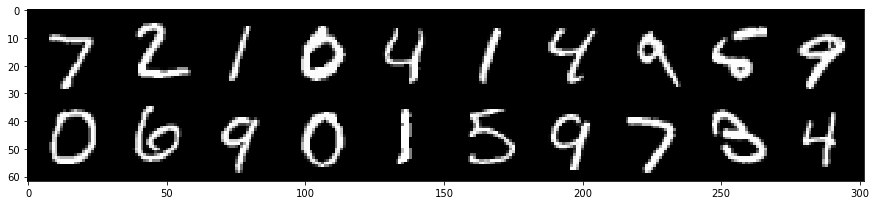

Generated images:


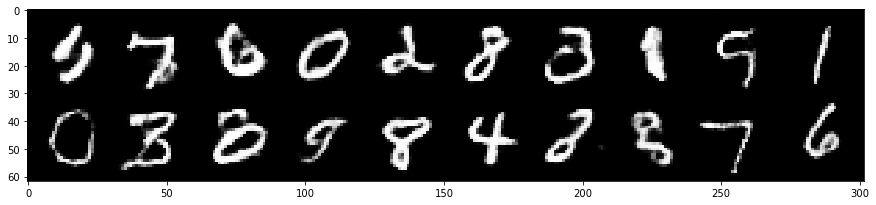

Model has finished training.

Training completed.


In [8]:
m = RunManager()
num_epochs = 150
num_samples = 20
num_critic_iters = 5

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a GAN model
    model = WGAN_GP(hparams.latent_dim, lambd=hparams.lambd)

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=num_samples)
    test_images, _ = next(iter(test_loader))
    
    # Define random samples from standard Normal distribution for image generation
    test_latents = torch.randn((num_samples, hparams.latent_dim))
    
    # Define optimizers
    d_optimizer = optim.Adam(model.critic.parameters(), lr=hparams.init_lr, betas=hparams.betas)
    g_optimizer = optim.Adam(model.generator.parameters(), lr=hparams.init_lr, betas=hparams.betas)
    d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, 60, 0.1)
    g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, 60, 0.1)
    model.set_optimizers(d_optimizer, g_optimizer)
    
    # Setup run instance
    m.begin_run(hparams, model, test_images, test_latents)
    model.display(test_images, test_latents)
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, latent_dim={2}, betas={3}, lambda={4}'
         .format(hparams.init_lr, hparams.batch_size, hparams.latent_dim, hparams.betas, hparams.lambd))
    
    # Start training loop
    for epoch in range(num_epochs):
        m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            images, _ = batch

            # Calculating the loss
            if i % num_critic_iters == 0:
                d_loss, gp, g_loss = model(images, train_generator=True)
            else:
                d_loss, gp = model(images, train_generator=False)
                g_loss = None
            
            if i % 10 == 0:
                print('Epoch {0}, iteration {1}: d_loss {2}, gp {3}, g_loss {4}'
                      .format(epoch+1, i*hparams.batch_size,
                              round(d_loss.item(), 6),
                              round(gp.item(), 6),
                              round(g_loss.item(), 6)))

            m.track_loss(d_loss, gp, g_loss)
            
        m.end_epoch()
    
    #torch.save(model, './models/' + str(hparams) + '.pth')
    m.end_run()
    print("Model has finished training.\n")
    d_scheduler.step()
    g_scheduler.step()
    
m.save('results_MNIST_final')
print("Training completed.")

## Produce generated examples

Latent dimension index: 0


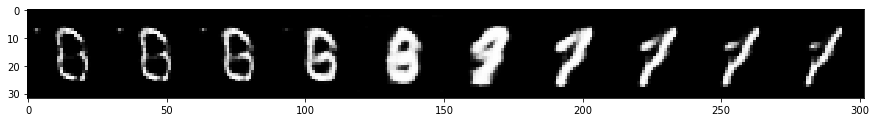

Latent dimension index: 1


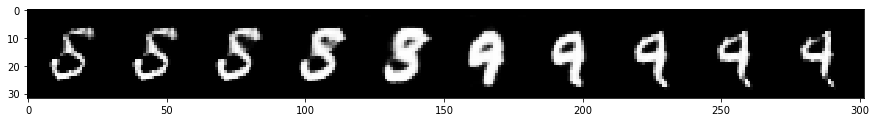

Latent dimension index: 2


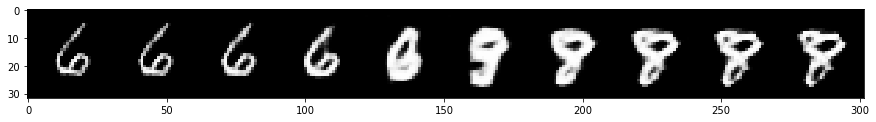

Latent dimension index: 3


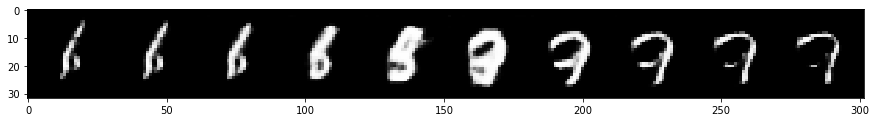

Latent dimension index: 4


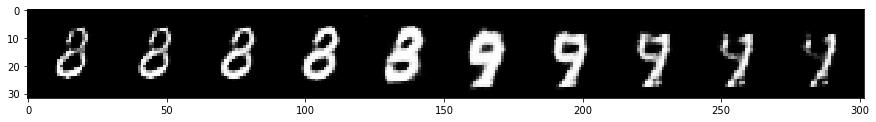

Latent dimension index: 5


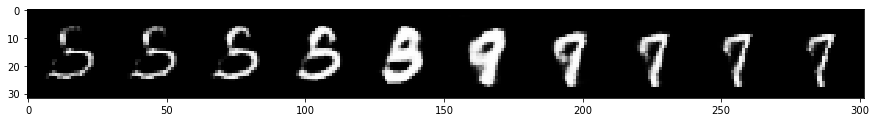

Latent dimension index: 6


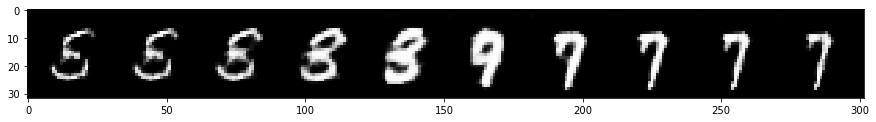

Latent dimension index: 7


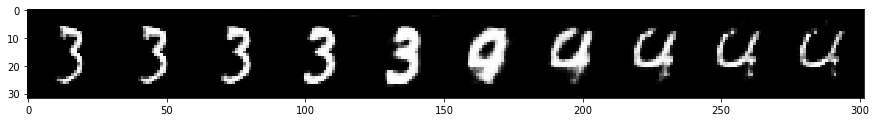

Latent dimension index: 8


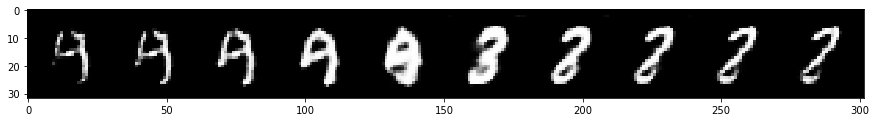

Latent dimension index: 9


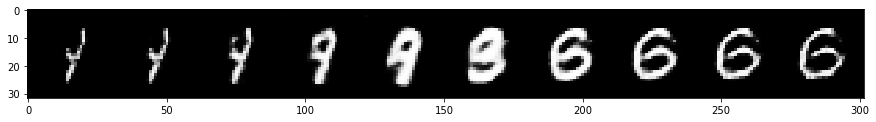

Latent dimension index: 10


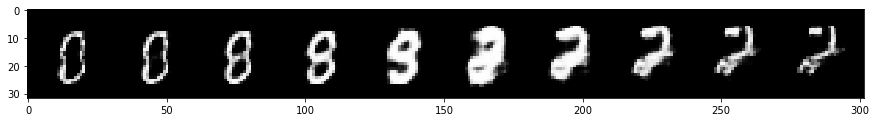

Latent dimension index: 11


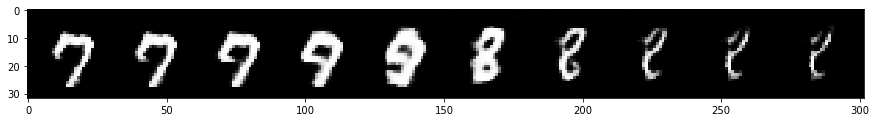

Latent dimension index: 12


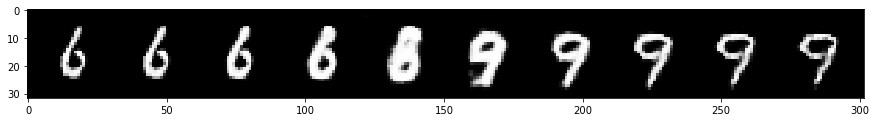

Latent dimension index: 13


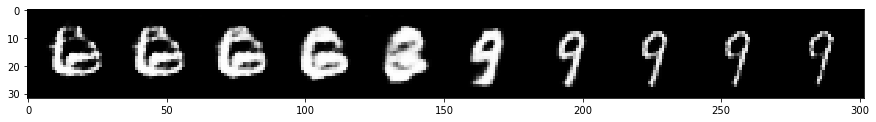

Latent dimension index: 14


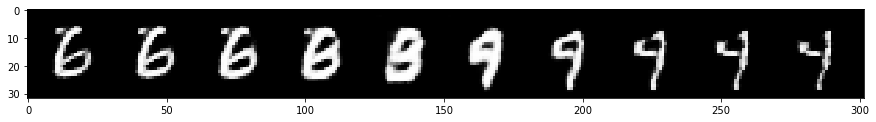

Latent dimension index: 15


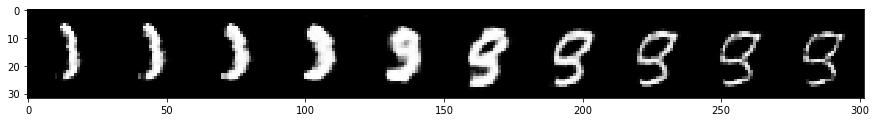

Latent dimension index: 16


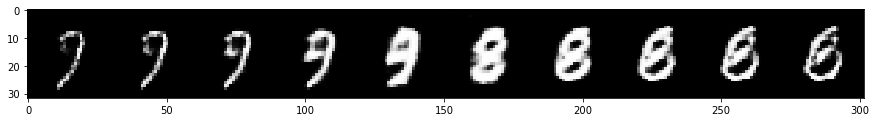

Latent dimension index: 17


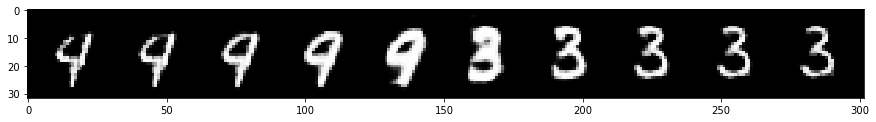

Latent dimension index: 18


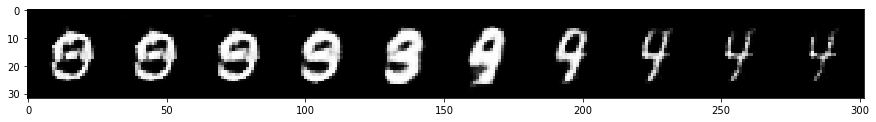

Latent dimension index: 19


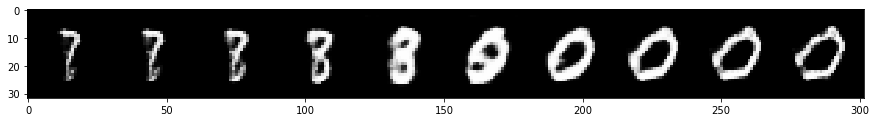

Latent dimension index: 20


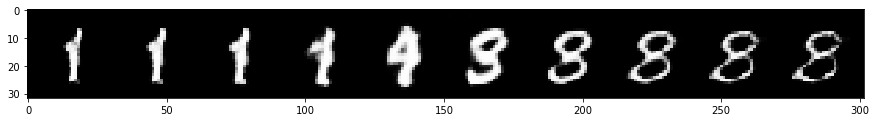

Latent dimension index: 21


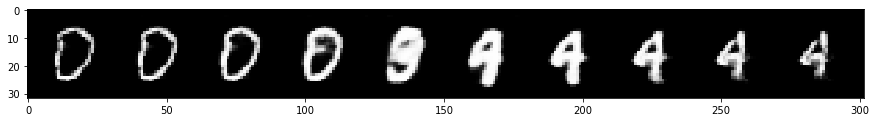

Latent dimension index: 22


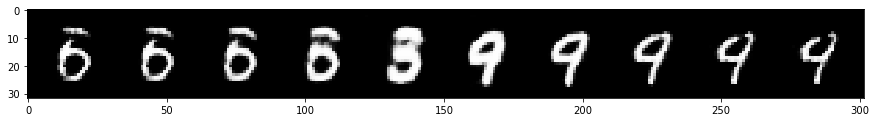

Latent dimension index: 23


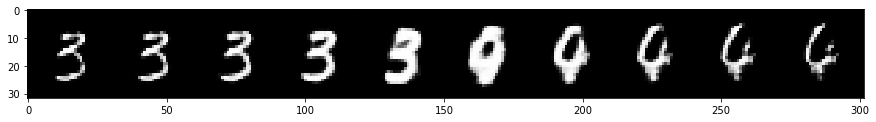

Latent dimension index: 24


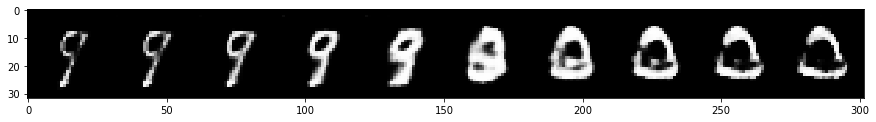

Latent dimension index: 25


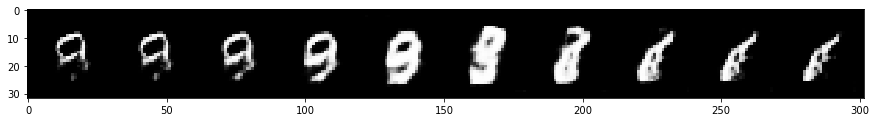

Latent dimension index: 26


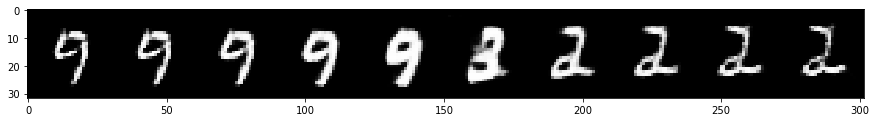

Latent dimension index: 27


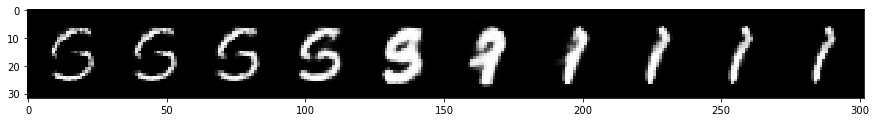

Latent dimension index: 28


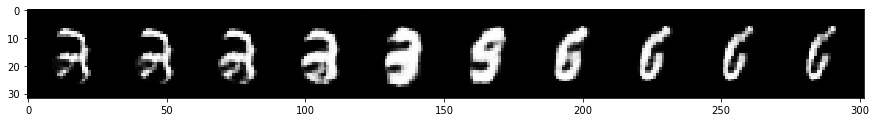

Latent dimension index: 29


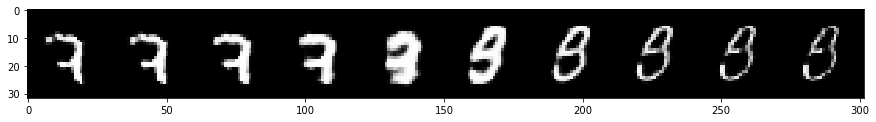

Latent dimension index: 30


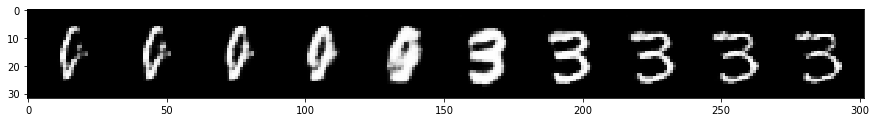

Latent dimension index: 31


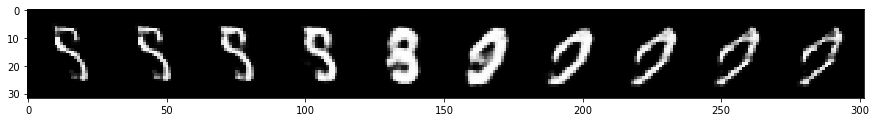

Latent dimension index: 32


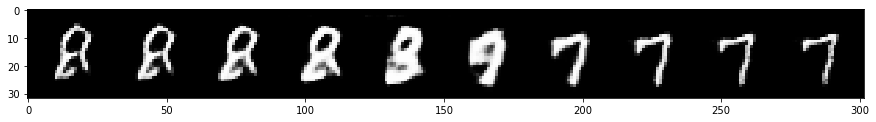

Latent dimension index: 33


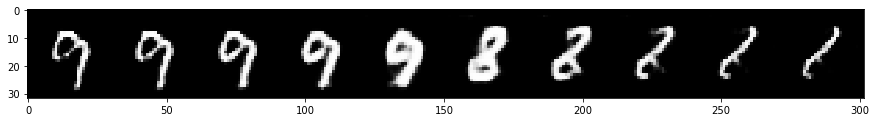

Latent dimension index: 34


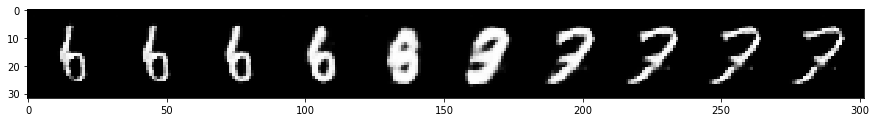

Latent dimension index: 35


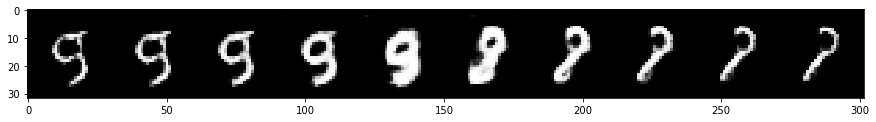

Latent dimension index: 36


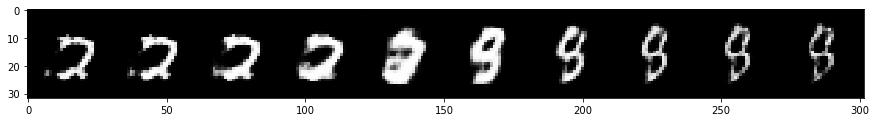

Latent dimension index: 37


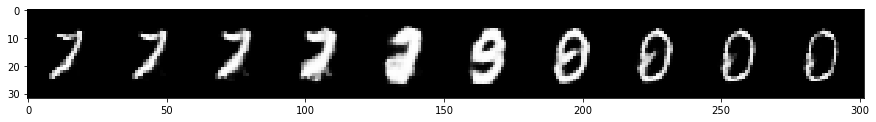

Latent dimension index: 38


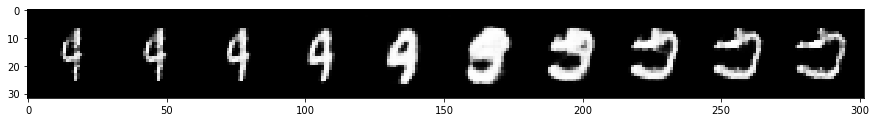

Latent dimension index: 39


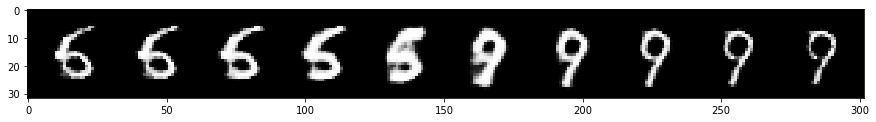

Latent dimension index: 40


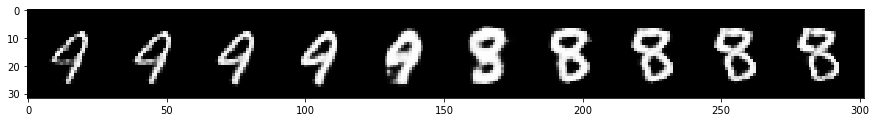

Latent dimension index: 41


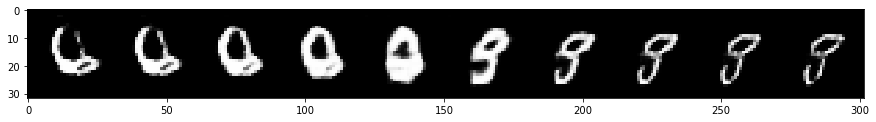

Latent dimension index: 42


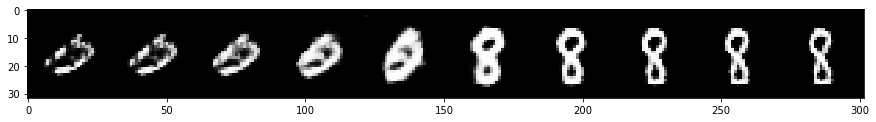

Latent dimension index: 43


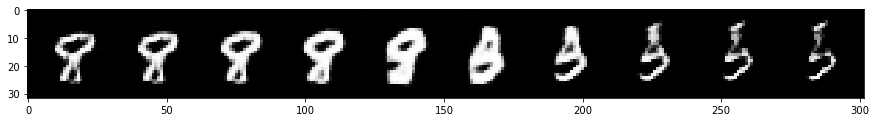

Latent dimension index: 44


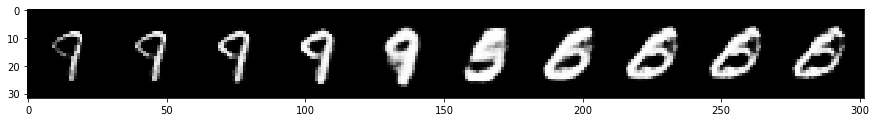

Latent dimension index: 45


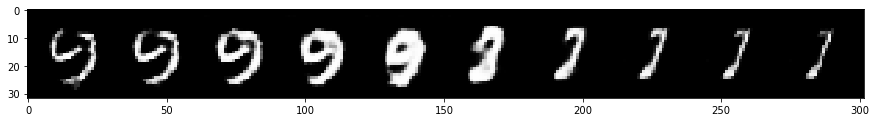

Latent dimension index: 46


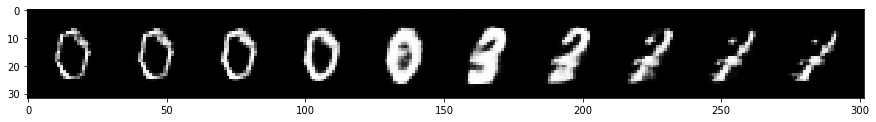

Latent dimension index: 47


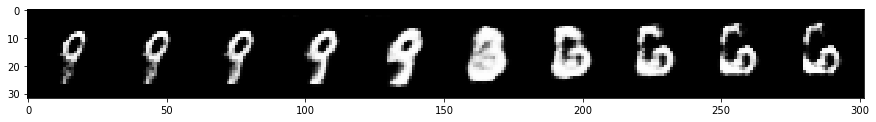

Latent dimension index: 48


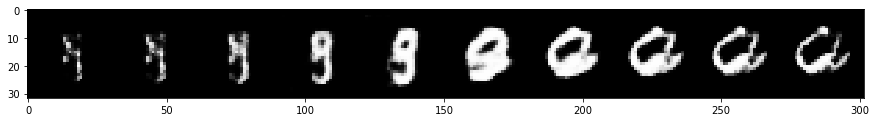

Latent dimension index: 49


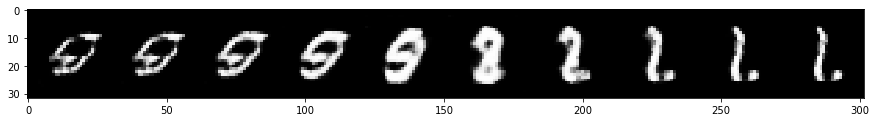

Latent dimension index: 50


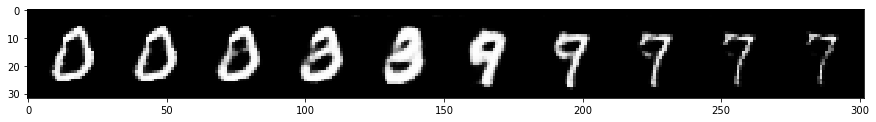

Latent dimension index: 51


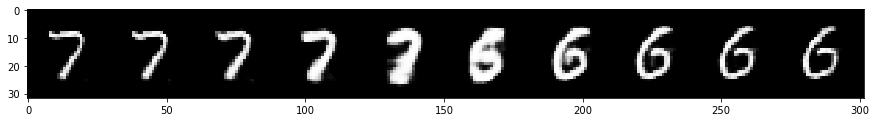

Latent dimension index: 52


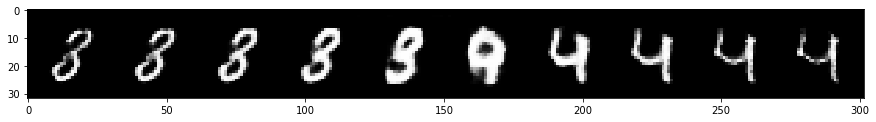

Latent dimension index: 53


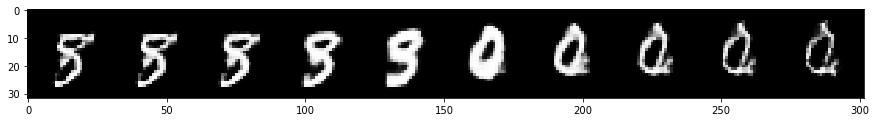

Latent dimension index: 54


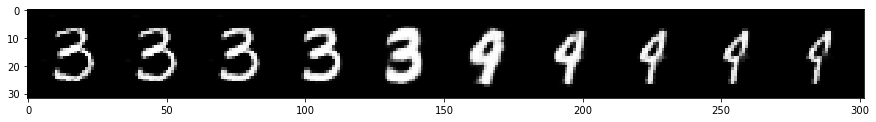

Latent dimension index: 55


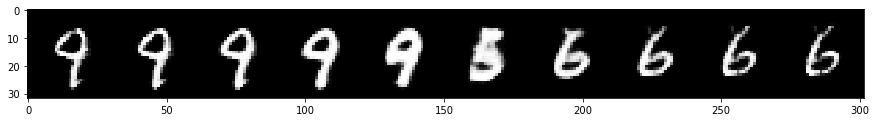

Latent dimension index: 56


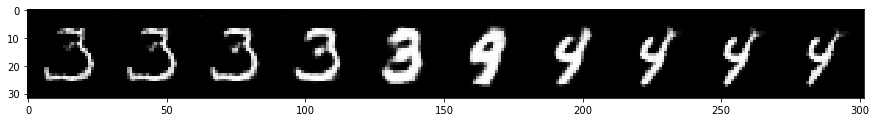

Latent dimension index: 57


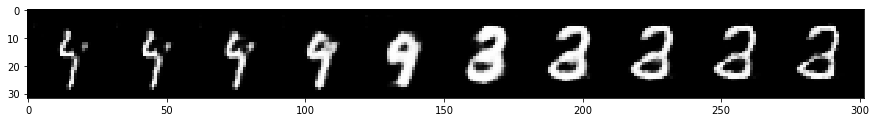

Latent dimension index: 58


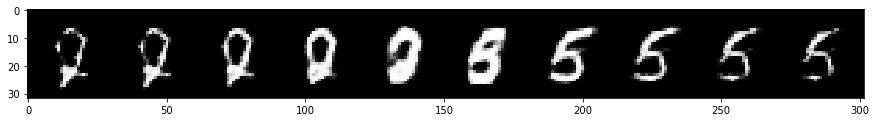

Latent dimension index: 59


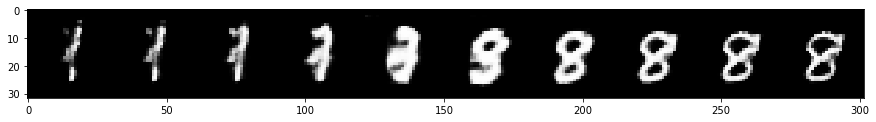

Latent dimension index: 60


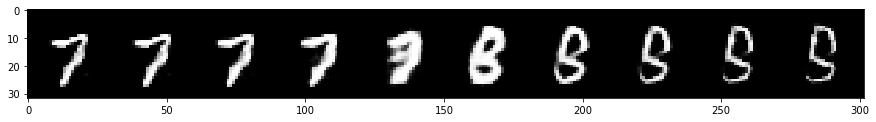

Latent dimension index: 61


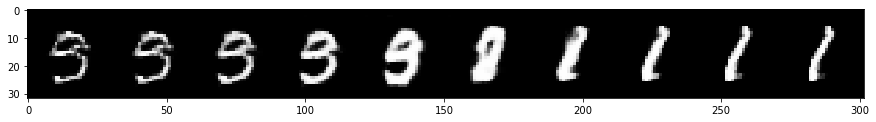

Latent dimension index: 62


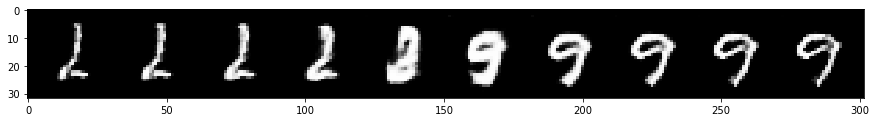

Latent dimension index: 63


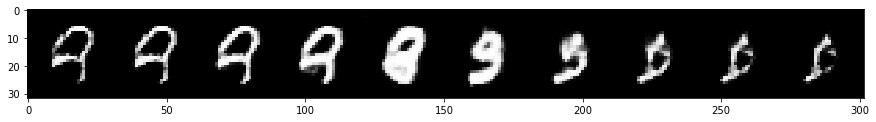

In [10]:
zs = np.linspace(-3, 3, 10)
for j in range(model.latent_dim):
    latents = torch.zeros((10, model.latent_dim))
    for i in range(10):
        latents[i,j] = zs[i]
    print("Latent dimension index:", j)
    with torch.no_grad():
        generated_imgs = model.generator(latents)
        imgviz(generated_imgs)

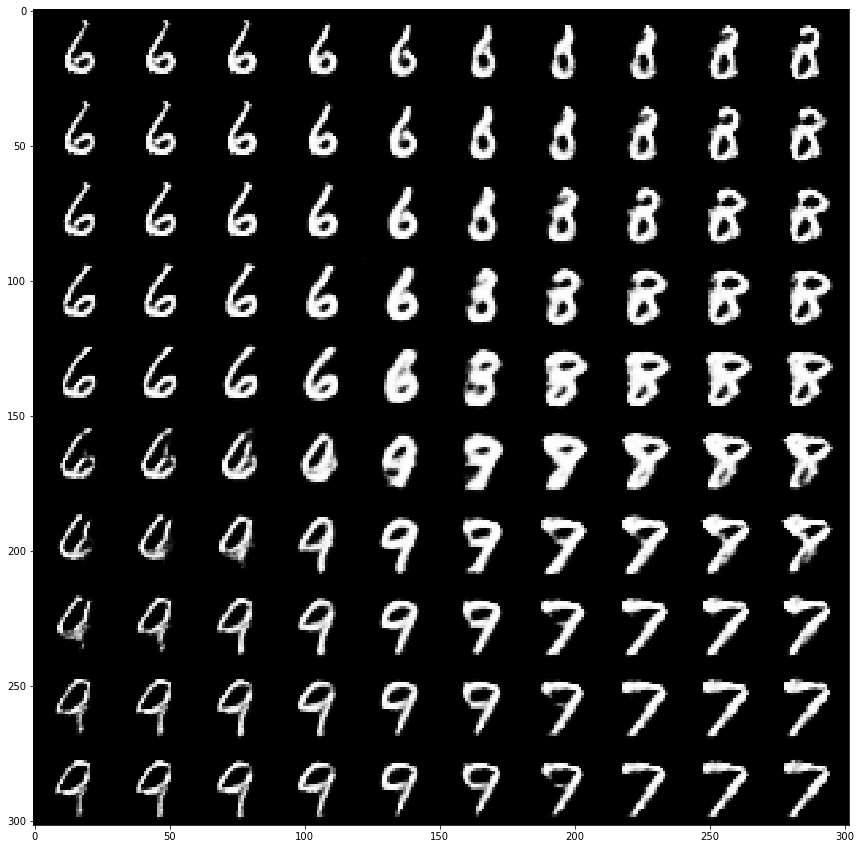

In [15]:
a = np.linspace(-3, 3, 10)
b0, b1 = np.meshgrid(a, a)
latents = torch.zeros((100, model.latent_dim))
for i in range(10):
    for j in range(10):
        latents[i*10+j,2] = b0[i,j]
        latents[i*10+j,12] = b1[i,j]
with torch.no_grad():
    generated_imgs = model.generator(latents)
    imgviz(generated_imgs, save_fname='MNIST_img.png')

## Losses

In [5]:
import pandas as pd

In [16]:
## Visualise losses in graph
df = pd.read_csv('./results_MNIST_final.csv', index_col=0)
epochs = np.array(list(range(3, 151)))
df.head()

,run,epoch,d_loss,gp,g_loss,epoch duration,run duration,init_lr,batch_size,latent_dim,betas,lambd
0,1,1,-11.929026,3.491811,-0.158959,990.831732,994.484871,0.0001,128,64,"(0, 0.9)",10
1,1,2,-8.046877,1.256759,-10.180714,1062.459682,2058.229555,0.0001,128,64,"(0, 0.9)",10
2,1,3,-3.993920,0.345886,-8.626339,1080.656741,3140.399474,0.0001,128,64,"(0, 0.9)",10
3,1,4,-3.749036,0.330559,-2.736269,1005.410336,4146.929025,0.0001,128,64,"(0, 0.9)",10
4,1,5,-3.936360,0.398442,-1.192995,979.899617,5128.090655,0.0001,128,64,"(0, 0.9)",10


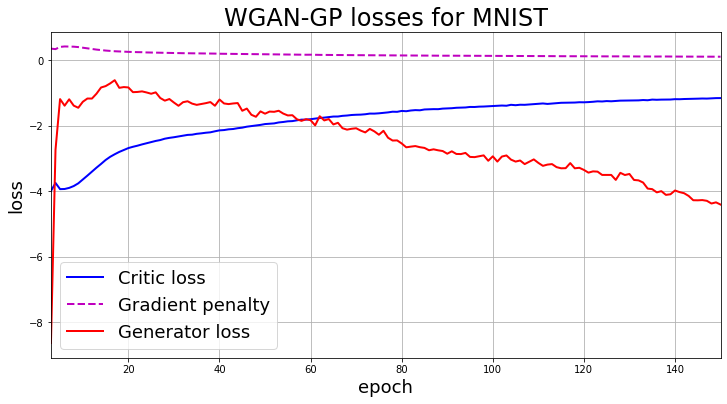

In [19]:
figure = plt.figure(figsize=(12,6))
plt.plot(epochs, df.d_loss[2:], 'b-', lw=2, label='Critic loss')
plt.plot(epochs, df.gp[2:], 'm--', lw=2, label='Gradient penalty')
plt.plot(epochs, df.g_loss[2:], 'r-', lw=2, label='Generator loss')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.title('WGAN-GP losses for MNIST', fontsize=24)
plt.xlim([3,150])
plt.legend(fontsize=18)
plt.grid('on')
plt.savefig('./losses_MNIST')
plt.show()